In [1]:
# import the packages
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score

<p>We are using F1 Score as model performance metric because its more appropriate in an imbalanced class problem</p>

<h3>Get the data</h3>

In [2]:
train = pd.read_csv('dataset/train.csv')
train.head()

,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_intl_calls,total_intl_charge,number_customer_service_calls,churn,area_code_area_code_415,area_code_area_code_510
0,97,1,0,0,236.9,107,105,13.40,241.0,120,2,1.97,0,1,0,1
1,28,0,0,0,168.2,87,92,13.74,192.4,112,3,2.73,3,0,1,0
2,120,0,0,0,180.0,80,82,19.06,265.4,91,7,1.27,3,0,1,0
3,80,0,1,33,189.4,109,68,12.64,208.9,119,4,3.02,1,1,1,0
4,100,0,0,0,239.1,96,110,15.31,259.2,112,2,3.78,0,0,0,0


In [3]:
test = pd.read_csv('dataset/test.csv')
test.head()

,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_intl_calls,total_intl_charge,number_customer_service_calls,churn,area_code_area_code_415,area_code_area_code_510
0,65,0,0,0,111.0,51,84,18.68,202.0,89,14,1.19,1,0,1,0
1,64,0,0,0,206.2,76,76,19.75,251.6,96,2,3.67,1,0,1,0
2,125,0,0,0,126.7,108,90,17.51,247.8,114,7,3.59,1,0,0,0
3,117,0,1,13,207.6,65,77,12.98,232.8,95,3,2.62,1,0,0,0
4,149,0,0,0,175.4,80,127,16.78,188.2,102,2,2.62,2,0,0,0


<p>We will use the test set only for final report on model performance</p>

In [4]:
# split the train data into train-dev set
from sklearn.model_selection import train_test_split

X = train.drop(['churn'], axis=1)
y = train['churn']

X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=0.2, random_state=42)

<h3>Baseline model</h3>

<p>For this problem, our baseline rule is to predict the class value that is most common in the training dataset. This means that if a training dataset has 90 instances of class "0" and 10 instances of class "1" that it will predict "0" and achieve a baseline accuracy of 90/100 or 90%.</p>

In [5]:
baseline_acc = len(train[train['churn'] == 0]) / len(train) * 100
baseline_acc

85.94117647058823

<h3>Logistic regression (vanilla)</h3>

In [30]:
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

logistic_basic = LogisticRegression(C=1e5) # initiate the model with random hyperparameter
logistic_basic.fit(X_train, y_train)

y_pred = np.array(logistic_basic.predict(X_dev))

print('Accuracy score: {:.3f}'.format(logistic_basic.score(X_dev, y_dev)))
print('F1 score: {:.3f}'.format(f1_score(y_dev, y_pred)))

Accuracy score: 0.868
F1 score: 0.250


In [31]:
# hyperparameters tuning
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV

logreg = LogisticRegression()
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
space['C'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]

search = GridSearchCV(logreg, space, scoring='f1', n_jobs=-1, cv=cv)

logreg_tuned = search.fit(X_train, y_train)

In [33]:
y_pred = np.array(logreg_tuned.predict(X_dev))

print('F1 score: {:.3f}'.format(f1_score(y_dev, y_pred)))
print('Best hyperparameters: {}'.format(logreg_tuned.best_params_))

F1 score: 0.297
Best hyperparameters: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}


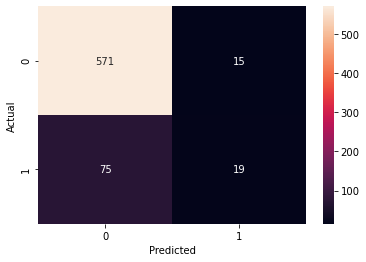

In [34]:
import seaborn as sns

conf_matrix = pd.crosstab(y_dev, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(conf_matrix, annot=True, fmt='g');

<h3>Logistic regression with SMOTE over-sampling</h3>

In [35]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train.ravel())

In [36]:
print('After over-sampling, counts of label "1": {}'.format(sum(y_train_res==1)))
print('After over-sampling, counts of label "0": {}'.format(sum(y_train_res==0)))

After over-sampling, counts of label "1": 2336
After over-sampling, counts of label "0": 2336


In [37]:
logreg = LogisticRegression()
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
space['C'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]

search = GridSearchCV(logreg, space, scoring='f1', n_jobs=-1, cv=cv)

logreg_smote_tuned = search.fit(X_train_res, y_train_res)

y_pred = np.array(logreg_smote_tuned.predict(X_dev))

print('F1 score: {:.3f}'.format(f1_score(y_dev, y_pred)))
print('Best hyperparameters: {}'.format(logreg_smote_tuned.best_params_))

F1 score: 0.406
Best hyperparameters: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}


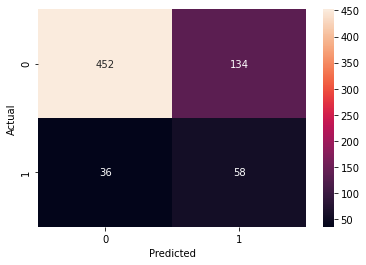

In [38]:
conf_matrix = pd.crosstab(y_dev, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(conf_matrix, annot=True, fmt='g');

<h3>Logistic regression: combination of SMOTE over-sampling with random undersampling</h3>

In [39]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

over = SMOTE(sampling_strategy=0.2)
under = RandomUnderSampler(sampling_strategy=0.6)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

X_train_res, y_train_res = pipeline.fit_resample(X_train, y_train)

print('After over-and-under-sampling, counts of label "1": {}'.format(sum(y_train_res==1)))
print('After over-and-under-sampling, counts of label "0": {}'.format(sum(y_train_res==0)))

After over-and-under-sampling, counts of label "1": 467
After over-and-under-sampling, counts of label "0": 778


In [40]:
logreg = LogisticRegression()
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
space['C'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]

search = GridSearchCV(logreg, space, scoring='f1', n_jobs=-1, cv=cv)

logreg_comb_tuned = search.fit(X_train_res, y_train_res)

y_pred = np.array(logreg_comb_tuned.predict(X_dev))

print('F1 score: {:.3f}'.format(f1_score(y_dev, y_pred)))
print('Best hyperparameters: {}'.format(logreg_comb_tuned.best_params_))

F1 score: 0.513
Best hyperparameters: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}


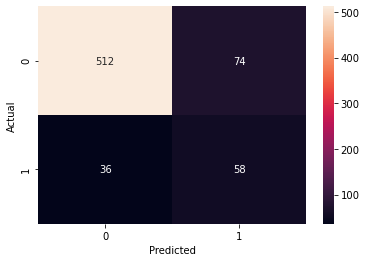

In [41]:
conf_matrix = pd.crosstab(y_dev, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(conf_matrix, annot=True, fmt='g');

<h3>Logistic regression with balanced class weights</h3>

In [42]:
logreg = LogisticRegression(class_weight='balanced')
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
space['C'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]

search = GridSearchCV(logreg, space, scoring='f1', n_jobs=-1, cv=cv)

logreg_balanced = search.fit(X_train, y_train)

y_pred = np.array(logreg_balanced.predict(X_dev))

print('F1 score: {:.3f}'.format(f1_score(y_dev, y_pred)))
print('Best hyperparameters: {}'.format(logreg_balanced.best_params_))

F1 score: 0.483
Best hyperparameters: {'C': 1, 'penalty': 'l2', 'solver': 'newton-cg'}


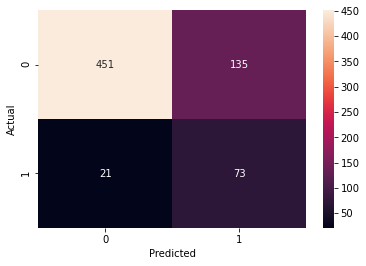

In [43]:
conf_matrix = pd.crosstab(y_dev, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(conf_matrix, annot=True, fmt='g');

<p>It seems like combining over-sampling with the under-sampling method generates a higher F1 Score than any other methods</p>

<h3>Put all  the pieces together</h3>

In [46]:
X_test = test.drop(['churn'], axis=1)
y_test = test['churn']

In [45]:
over = SMOTE(sampling_strategy=0.2)
under = RandomUnderSampler(sampling_strategy=0.6)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

X_train_res, y_train_res = pipeline.fit_resample(X, y)

print('After over-and-under-sampling, counts of label "1": {}'.format(sum(y_train_res==1)))
print('After over-and-under-sampling, counts of label "0": {}'.format(sum(y_train_res==0)))

After over-and-under-sampling, counts of label "1": 584
After over-and-under-sampling, counts of label "0": 973


In [47]:
logreg = LogisticRegression()
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
space['C'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]

search = GridSearchCV(logreg, space, scoring='f1', n_jobs=-1, cv=cv)

logreg_comb_tuned = search.fit(X_train_res, y_train_res)

y_pred = np.array(logreg_comb_tuned.predict(X_test))

print('F1 score: {:.3f}'.format(f1_score(y_test, y_pred)))
print('Best hyperparameters: {}'.format(logreg_comb_tuned.best_params_))

F1 score: 0.519
Best hyperparameters: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}


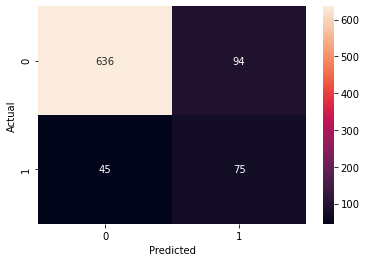

In [48]:
conf_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(conf_matrix, annot=True, fmt='g');